# Symbolic Machine Learning

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/ml/symbolic_ml.ipynb)

Machine learning (ML) is sensitive to neural architectures and hyperparameters, making their representation critical to the design of an ML system. ML practitioners rely on these representations to conduct experiments and deploy models in production.

In a traditional ML system, ML components are built to serve the system's purpose, with a separate configuration system used to adjust their hyperparameters. This requires developers and users to maintain a mapping between the components and their configurations, ensuring that they remain consistent. PyGlove offers an alternative approach by using symbolic classes to develop ML components. Symbolic objects are a natural and mutable representation of these components, eliminating the need for a separate configuration system. As a result, symbolic ML systems are simpler and more user-friendly. In this Colab, we provide an example of a symbolic ML pipeline that can support the entire experimentation life-cycle with ease and power.

In [ ]:
!pip install pyglove

<a name="overview"></a>
## An Overview of a Symbolic ML Experiment

In PyGlove, an ML pipeline (or experiment) can be represented as a symbolic object - an object that can be manipulated safely after their creation based on their construction signatures. The root object is the whole experiment, whose sub-nodes are symbolic objects of ML components that specify the details of the experiment. 

All ML components (including the `Experiment` class) are symbolic, meaning that they can be safely manipulated after creation. With PyGlove, users can create a symbolic class by extending `pg.Object` or symbolizing a regular class via `pg.symbolize`. The code below shows the definition of `Experiment` class, and lower-level ML components symbolized from functions or Keras classes.

In [ ]:
import tensorflow as tf
import pyglove as pg

@pg.members([
  ('model', pg.typing.Object(tf.keras.Model),
   'Model used for both training and evaluation.'),
  ('training', pg.typing.Dict([
    ('input', pg.typing.Callable(), 
     'A callable that returns a tuple of (features, labels) for training.'),
    ('batch_size', pg.typing.Int(min_value=1),
     'Training batch size.'),
    ('num_epochs', pg.typing.Int(min_value=1),
     'Number of epochs for training.'),
    ('loss', pg.typing.Object(tf.keras.losses.Loss),
     'Loss used for optimization.'),
    ('optimizer', pg.typing.Object(tf.keras.optimizers.Optimizer),
     'Optimizer for minimizing the loss.'),
  ])),
  ('evaluation', pg.typing.Dict([
    ('input', pg.typing.Callable(),
     'A callable that returns a tuple of (feature, labels) for evaluation.'),
    ('batch_size', pg.typing.Int(min_value=1),
     'Evaluation batch size.'),
    ('metric', pg.typing.Object(tf.keras.metrics.Metric),
     'Evaluation metrics.')
  ]))
])
class Experiment(pg.Object):

  def run(self):
    self.model.compile(
        optimizer=self.training.optimizer,
        loss=self.training.loss,
        metrics=[self.evaluation.metric])
    x_train, y_train = self.training.input()
    self.model.fit(x_train, y_train, epochs=self.training.num_epochs)

    x_test, y_test = self.evaluation.input()
    _, test_metric = self.model.evaluate(x_test, y_test)
    return test_metric


# Create an experiment instance.
@pg.symbolize
def mnist(training):
  (x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0
  if training:
    x_train /= 255.0
    return x_train, y_train
  else:
    x_test /= 255.0
    return x_test, y_test

# Symbolize regular Keras classes to make them serializable.
Sequential = pg.symbolize(tf.keras.Sequential)
Flatten = pg.symbolize(tf.keras.layers.Flatten)
Dense = pg.symbolize(tf.keras.layers.Dense)
Dropout = pg.symbolize(tf.keras.layers.Dropout)
Adam = pg.symbolize(tf.keras.optimizers.Adam)
SparseCategoricalCrossentropy = pg.symbolize(
    tf.keras.losses.SparseCategoricalCrossentropy)
SparseCategoricalAccuracy = pg.symbolize(
    tf.keras.metrics.SparseCategoricalAccuracy)

With symbolic classes, an experiment can be expressed as an `Experiment`. And we can run the experiment by calling its `run` method, and save it for reproduction later.

In [ ]:
# Create an instance of Experiment via composition.
exp1 = Experiment(
  model=Sequential(layers=[
     Flatten(input_shape=(28, 28)),
     Dense(1024, activation='relu'),
     Dropout(0.2),
     Dense(10, activation='softmax')
  ]),
  training=pg.Dict(
      input=mnist(training=True),
      batch_size=32,
      num_epochs=2,
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
  ),
  evaluation=pg.Dict(
      input=mnist(training=False),
      batch_size=32,
      metric=SparseCategoricalAccuracy()
  ))

# Run and save experiment.
exp1.run()
exp1.save('exp1.json')

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 9s 4ms/step - loss: 0.7588 - sparse_categorical_accuracy: 0.8040
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.9105


<a name="lifecycle"></a>
## Life-cycle of a Symbolic ML Experiment

Most advancements in machine learning are based on iterating existing experiments. The life-cycle for experimenting a new idea can be described in 4 phases:

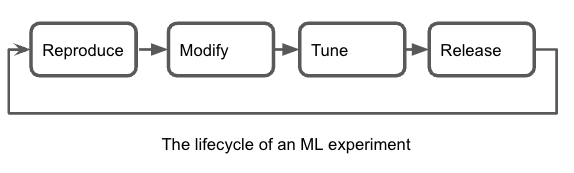

<a name="reproduction"></a>
### Reproduction

Reproducing an existing experiment is simply clone the existing experiment object, or load if from a saved JSON file.

In [ ]:
experiment = exp1.clone(deep=True)
assert pg.eq(experiment, exp1)

experiment = pg.load('exp1.json')
assert pg.eq(experiment, exp1)

experiment.run()

Epoch 1/2
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7663 - sparse_categorical_accuracy: 0.8054
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 0.3026 - sparse_categorical_accuracy: 0.9126


0.9125999808311462

<a name="modification"></a>
### Modification

To iterate an idea, an existing ML experiment needs to be modified into new ones. With PyGlove, a symbolic object can be manipluated into another object without modifying existing code. This gives the maximum flexibility to accomondate unanticpated changes when new ideas pop up.


In [ ]:
@pg.symbolize
class NewModel(tf.keras.Model):

  def __init__(self, activation):
    super().__init__()
    self._dense1 = Dense(1024, activation=activation)
    self._dense2 = Dense(10, activation='softmax')
  
  def call(self, inputs):
    x = Flatten()(inputs)
    x = self._dense1(x)
    x = Dropout(0.2)(x)
    x = self._dense2(x)
    return x

ReLU = pg.symbolize(tf.keras.layers.ReLU)
RMSProp = pg.symbolize(tf.keras.optimizers.RMSprop)

experiment.rebind({
  'model': NewModel(activation=ReLU()),
  'training.batch_size': 256,
  'training.optimizer': RMSProp(0.01)
})
print(experiment)
experiment.run()

Experiment(
  model = NewModel(
    activation = ReLU(
      max_value = None,
      negative_slope = 0.0,
      threshold = 0.0
    )
  ),
  training = {
    input = mnist(
      training = True
    ),
    batch_size = 256,
    num_epochs = 2,
    loss = SparseCategoricalCrossentropy(
      from_logits = False,
      reduction = 'auto',
      name = 'sparse_categorical_crossentropy'
    ),
    optimizer = RMSprop(
      learning_rate = 0.01,
      rho = 0.9,
      momentum = 0.0,
      epsilon = 1e-07,
      centered = False,
      name = 'RMSprop'
    )
  },
  evaluation = {
    input = mnist(
      training = False
    ),
    batch_size = 32,
    metric = SparseCategoricalAccuracy(
      name = 'sparse_categorical_accuracy',
      dtype = None
    )
  }
)
Epoch 1/2
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3879 - sparse_categorical_accuracy: 0.8869
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1477 - sparse_categorical_accuracy:

0.9580000042915344

<a name="tuning"></a>
### Tuning

Once an idea works, ML practitioners can squeeze out the performance by tuning its hyperparameters. With PyGlove, ML practitioners can tune any part of the experiment with ease. Here we do a hyperparameter sweep on both learning rate for the model.

In [ ]:
ssd = experiment.clone(deep=True).rebind({
    'training.optimizer.learning_rate': 
pg.oneof([1e-2, 1e-1]),
})

for exp, feedback in pg.sample(ssd, pg.geno.Sweeping()):
  print(f'Trial {feedback.id}: {feedback.dna}')
  accuracy = exp.run()
  feedback(accuracy)

Trial 1: DNA(0)
Epoch 1/2
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.8812
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9527
Trial 2: DNA(1)
Epoch 1/2
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5973 - sparse_categorical_accuracy: 0.8466
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 0.3198 - sparse_categorical_accuracy: 0.9268


<a name="release"></a>
### Release

Release is simply to save the experiment for future reproduction, with making all new components available to others.

In [ ]:
experiment.save('exp2.json')

<a name="symbolic-features"></a>
## The Power of Symbolic Machine Learning

The power of symbolic ML is revealed during the whole process of experimentation, from boosting the productivity of developement and iterations, to implementing ideas with new ways of programming, and applying AutoML.

<a name="productivity-features"></a>
### Experimenting with More Productivity



#### Rich formatting in human-readable form

In [ ]:
print(experiment)

Experiment(
  model = NewModel(
    activation = ReLU(
      max_value = None,
      negative_slope = 0.0,
      threshold = 0.0
    )
  ),
  training = {
    input = mnist(
      training = True
    ),
    batch_size = 256,
    num_epochs = 2,
    loss = SparseCategoricalCrossentropy(
      from_logits = False,
      reduction = 'auto',
      name = 'sparse_categorical_crossentropy'
    ),
    optimizer = RMSprop(
      learning_rate = 0.01,
      rho = 0.9,
      momentum = 0.0,
      epsilon = 1e-07,
      centered = False,
      name = 'RMSprop'
    )
  },
  evaluation = {
    input = mnist(
      training = False
    ),
    batch_size = 32,
    metric = SparseCategoricalAccuracy(
      name = 'sparse_categorical_accuracy',
      dtype = None
    )
  }
)


In [ ]:
# A single-line print.
print(repr(experiment))

Experiment(model=NewModel(activation=ReLU(max_value=None, negative_slope=0.0, threshold=0.0)), training={input=mnist(training=True), batch_size=256, num_epochs=2, loss=SparseCategoricalCrossentropy(from_logits=False, reduction='auto', name='sparse_categorical_crossentropy'), optimizer=RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')}, evaluation={input=mnist(training=False), batch_size=32, metric=SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)})


In [ ]:
# Print with docstr, and hide the default values.
print(pg.format(experiment, verbose=True, hide_default_values=True))

Experiment(
  # Model used for both training and evaluation.
  model = NewModel(
    # Argument 'activation'.
    activation = ReLU()
  ),
  training = {
    # A callable that returns a tuple of (features, labels) for training.
    input = mnist(
      # Argument 'training'.
      training = True
    ),

    # Training batch size.
    batch_size = 256,

    # Number of epochs for training.
    num_epochs = 2,

    # Loss used for optimization.
    loss = SparseCategoricalCrossentropy(),

    # Optimizer for minimizing the loss.
    optimizer = RMSprop(
      # Argument 'learning_rate'.
      learning_rate = 0.01
    )
  },
  evaluation = {
    # A callable that returns a tuple of (feature, labels) for evaluation.
    input = mnist(
      # Argument 'training'.
      training = False
    ),

    # Evaluation batch size.
    batch_size = 32,

    # Evaluation metrics.
    metric = SparseCategoricalAccuracy()
  }
)


#### Retrieving the schema of hyper-parameters

In [ ]:
print(Experiment.schema)

Schema(
  # Model used for both training and evaluation.
  model = Object(Model),

  training = Dict({
    # A callable that returns a tuple of (features, labels) for training.
    input = Callable(),

    # Training batch size.
    batch_size = Int(min=1),

    # Number of epochs for training.
    num_epochs = Int(min=1),

    # Loss used for optimization.
    loss = Object(Loss),

    # Optimizer for minimizing the loss.
    optimizer = Object(OptimizerV2)
  }),
  evaluation = Dict({
    # A callable that returns a tuple of (feature, labels) for evaluation.
    input = Callable(),

    # Evaluation batch size.
    batch_size = Int(min=1),

    # Evaluation metrics.
    metric = Object(Metric)
  })
)


#### Catching bad experiment specifications

In [ ]:
try:
  experiment.rebind({
      # Misput batch size.
      'training.batch_size': 0
  })
except ValueError as e:
  print(e)

Value 0 is out of range (min=1, max=None). (path=training.batch_size)


#### Showing the differences between two experiments

In [ ]:
print(pg.diff(experiment, experiment.clone(override={
    'training.batch_size': 128,
    'training.optimizer.learning_rate': 0.2
})))

Experiment(
  training = Dict(
    batch_size = Diff(
      left = 256,
      right = 128
    ),
    optimizer = RMSprop(
      learning_rate = Diff(
        left = 0.01,
        right = 0.2
      )
    )
  )
)


#### Querying parts of an experiment

The ML experiment is now a symbolic tree, which can be queried by nodes' locations or values.

In [ ]:
# Query by key path.
pg.query(experiment, '.*input')

{'evaluation.input': mnist(training=False),
 'training.input': mnist(training=True)}

In [ ]:
# Query by values.
pg.query(experiment, where=lambda v: isinstance(v, bool))

{'evaluation.input.training': False,
 'training.input.training': True,
 'training.loss.from_logits': False,
 'training.optimizer.centered': False}

#### Meta-programming by traversing the experiment

In [ ]:
def list_keys(key, value, parent):
  print(key)

pg.traverse(experiment, list_keys)


model
model.activation
model.activation.max_value
model.activation.negative_slope
model.activation.threshold
training
training.input
training.input.training
training.batch_size
training.num_epochs
training.loss
training.loss.from_logits
training.loss.reduction
training.loss.name
training.optimizer
training.optimizer.learning_rate
training.optimizer.rho
training.optimizer.momentum
training.optimizer.epsilon
training.optimizer.centered
training.optimizer.name
evaluation
evaluation.input
evaluation.input.training
evaluation.batch_size
evaluation.metric
evaluation.metric.name
evaluation.metric.dtype


True

#### Comparing concepts

When the user want to check if two components have the same symbolic representation, symbolic comparison can be applied.


In [ ]:
print(pg.eq(experiment, exp1))
print(pg.eq(experiment, experiment.clone(deep=True)))

False
True


#### Saving/Loading concepts

Objects can be serialized solely based on their symbolic representation, regardless their internal states.

In [ ]:
pg.eq(experiment, pg.from_json_str(experiment.to_json_str()))

True

#### Preventing an object from further modification

In [ ]:
experiment.seal()
try:
  experiment.rebind({
      'training.batch_size': 5
  })
except pg.WritePermissionError as e:
  print(e)
experiment.seal(False)

Cannot rebind key 'batch_size' of sealed Dict: {input=mnist(training=True), batch_size=256, num_epochs=2, loss=SparseCategoricalCrossentropy(from_logits=False, reduction='auto', name='sparse_categorical_crossentropy'), optimizer=RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')}. (path='training')


Experiment(model=NewModel(activation=ReLU(max_value=None, negative_slope=0.0, threshold=0.0)), training={input=mnist(training=True), batch_size=256, num_epochs=2, loss=SparseCategoricalCrossentropy(from_logits=False, reduction='auto', name='sparse_categorical_crossentropy'), optimizer=RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')}, evaluation={input=mnist(training=False), batch_size=32, metric=SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)})

<a name="manipulation"></a>
### Riding the Power of Symbolic Manipulation

Symbolic manipulation allows modification of the parts of an experiment after its creation. Moreover, it provides programming interfaces to meta-program the experiment by rules or algorithms. 


#### Encapsulating ideas and making them reusable

For common software systems, code reuse happens at type definition level; for traditional ML systems, code reuse happens at instance level (e.g. reusing an experiment). For symbolic ML systems, code reuse can takes place at an even higher level - the procedure (meta-program) that transforms object A to object B. Essentially, such meta-programs encapsulates ideas that make ML effective, such as linear scaling of learning rate when batch size increaes, replacing ReLU layers with ELu layers, and etc.

In [ ]:
@pg.patcher([
  ('batch_size', pg.typing.Int(min_value=1))
])
def scale_lr_with_batch_size(exp, batch_size):
  # A patcher returns a dict of location to updated values
  # within the patching target.
  return {
      'training.batch_size': batch_size,
      'training.optimizer.learning_rate': (
          exp.training.optimizer.sym_init_args.learning_rate * (
              batch_size / exp.training.batch_size))
  }

new_experiment = experiment.clone(deep=True)
pg.patch(new_experiment, scale_lr_with_batch_size(batch_size=1024))
print(pg.diff(experiment, new_experiment))

Experiment(
  training = Dict(
    batch_size = Diff(
      left = 256,
      right = 1024
    ),
    optimizer = RMSprop(
      learning_rate = Diff(
        left = 0.01,
        right = 0.04
      )
    )
  )
)


Patcher can also by defined as transforms that is based on patterns in the symbolic tree. For example, swapping all ReLU activations to ELU can be expressed as

In [ ]:
ELU = pg.symbolize(tf.keras.layers.ELU)

@pg.patcher()
def relu_to_elu(unused_exp):
  def _swap_activation(k, v, p):
    """Transform fn for each node in the symbolic tree in bottom-up a manner.

    Args:
      k: a `pg.KeyPath` object representing the location of current node.
      v: the value of current node.
      p: the parent node.

    Returns:
      Transformed value.
    """
    if isinstance(v, ReLU):
      return ELU()
    return v
  return _swap_activation

new_experiment = experiment.clone(deep=True)
pg.patch(new_experiment, relu_to_elu())
print(pg.diff(experiment, new_experiment))

Experiment(
  model = NewModel(
    activation = Diff(
      left = ReLU(
        max_value = None,
        negative_slope = 0.0,
        threshold = 0.0
      ),
      right = ELU(
        alpha = 1.0
      )
    )
  )
)


#### Combining ideas

Ideas can be easily combined by chaining the patchers together. For example, we can apply both techiniques introduced above to a new experiment by:

In [ ]:
new_experiment = experiment.clone(deep=True)
# Combining ideas by chaining the patchers.
pg.patch(new_experiment, [
    scale_lr_with_batch_size(batch_size=1024),
    relu_to_elu(),
])
print(pg.diff(experiment, new_experiment))

Experiment(
  model = NewModel(
    activation = Diff(
      left = ReLU(
        max_value = None,
        negative_slope = 0.0,
        threshold = 0.0
      ),
      right = ELU(
        alpha = 1.0
      )
    )
  ),
  training = Dict(
    batch_size = Diff(
      left = 256,
      right = 1024
    ),
    optimizer = RMSprop(
      learning_rate = Diff(
        left = 0.01,
        right = 0.04
      )
    )
  )
)


#### Patching experiment from the command line

Though it's easy to patch experiments via Python code. It would be better if ML practitioners can patch experiments from the command line, which requires no rebuild/repackage of the source code.

To address this requirement, patcher can also be invoked as a URL-like string. Therefore, the strings can be passed in as command-line arguments.

In [ ]:
print(pg.diff(experiment, pg.patch(experiment.clone(deep=True), [
    'scale_lr_with_batch_size?batch_size=1024',
    'relu_to_elu'
])))

Experiment(
  model = NewModel(
    activation = Diff(
      left = ReLU(
        max_value = None,
        negative_slope = 0.0,
        threshold = 0.0
      ),
      right = ELU(
        alpha = 1.0
      )
    )
  ),
  training = Dict(
    batch_size = Diff(
      left = 256,
      right = 1024
    ),
    optimizer = RMSprop(
      learning_rate = Diff(
        left = 0.01,
        right = 0.04
      )
    )
  )
)


#### Summary: A better expression of ML experiment

Putting things together, a new experiment can be expressed as an existing experiment applying new ML ideas, with each patcher represents an ML idea. Such expression is more high-level than hyperparameter-level differences, and better reasons their differencs. Moreover, the ML ideas can be applied to other experiments too.


See also:

* [Symbolic Neural Modeling](https://github.com/google/pyglove/blob/main/docs/notebooks/ml/neural_modeling.ipynb)

<a name="automl"></a>
### Embracing AutoML as a Part of the ML Experimentation Process

Machine learning is a process of trials and errors. Today, most of such trials are manually done with human-conducted evolution, a repeated and laboring process. On the other hand, automatic hyperparameter tuning is not a stranger, it's often supported for large scale ML systems. More complex automatic explorations, like neural architecture search, however, are still considered advanced technologies that most ML practioners do not have access to. 

AutoML should be an integral part of ML experimentation process, and it should be straightforward for every ML practioner. PyGlove enables this with a few lines of code changes. This means, an arbitrary part of an ML experiment can be added to the search space easily, and to be optimized by state-of-the-art search algorithms.


#### Defining what to explore



In [ ]:
# Let's take another look of the experiment.
print(experiment)

Experiment(
  model = NewModel(
    activation = ReLU(
      max_value = None,
      negative_slope = 0.0,
      threshold = 0.0
    )
  ),
  training = {
    input = mnist(
      training = True
    ),
    batch_size = 256,
    num_epochs = 2,
    loss = SparseCategoricalCrossentropy(
      from_logits = False,
      reduction = 'auto',
      name = 'sparse_categorical_crossentropy'
    ),
    optimizer = RMSprop(
      learning_rate = 0.01,
      rho = 0.9,
      momentum = 0.0,
      epsilon = 1e-07,
      centered = False,
      name = 'RMSprop'
    )
  },
  evaluation = {
    input = mnist(
      training = False
    ),
    batch_size = 32,
    metric = SparseCategoricalAccuracy(
      name = 'sparse_categorical_accuracy',
      dtype = None
    )
  }
)


Now assume that we have three ideas:
* Try different activations.
* Try different optimizers.
* Try different batch size.

We can make a search space with jointly optimizing these three apsects:



In [ ]:
SGD = pg.symbolize(tf.keras.optimizers.SGD)
Adam = pg.symbolize(tf.keras.optimizers.Adam)
PReLU = pg.symbolize(tf.keras.layers.PReLU)

learning_rate = 0.001

experiment_space = experiment.clone(override={
    'model.activation': pg.oneof([ReLU(), ELU(), PReLU()]),
    'training.optimizer': pg.oneof([
        RMSProp(learning_rate=learning_rate),
        SGD(learning_rate=learning_rate),
        Adam(learning_rate=learning_rate),
    ]),
    'training.batch_size': pg.oneof([32, 64, 128])
})

# Let's inspect the decision points from this space:
print(pg.dna_spec(experiment_space))

Space({
  0 = 'model.activation': Choices(num_choices=1, [
    (0): ReLU()
    (1): ELU()
    (2): PReLU()
  ])
  1 = 'training.batch_size': Choices(num_choices=1, [
    (0): 32
    (1): 64
    (2): 128
  ])
  2 = 'training.optimizer': Choices(num_choices=1, [
    (0): RMSprop()
    (1): SGD(learning_rate=0.001)
    (2): Adam()
  ])
})


In [ ]:
# Check the size of the space.
print(pg.dna_spec(experiment_space).space_size)

27


#### Automatic exploration with regularized evolution

With an experiment space, we can specify how to optimize based on:

* Search algorithm: we use regularized evolution here.
* Reward function: we use accuracy as the reward.

In [ ]:
best_exp, best_accuracy = None, None
history = []
for exp, feedback in pg.sample(experiment_space,
                               pg.evolution.regularized_evolution(
                                   population_size=5, tournament_size=3),
                               num_examples=20):
  print(f'Trial {feedback.id}: {feedback.dna}')
  accuracy = exp.run()
  if best_accuracy is None or best_accuracy < accuracy:
    best_accuracy, best_exp = accuracy, exp
  history.append(accuracy)
  feedback(accuracy)

print(f'Best acurracy: {best_accuracy}')
print(f'Best experiment: {best_exp}')

Trial 1: DNA([2, 0, 0])
Epoch 1/2
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7484 - sparse_categorical_accuracy: 0.8067
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 0.2791 - sparse_categorical_accuracy: 0.9189
Trial 2: DNA([0, 2, 1])
Epoch 1/2
1875/1875 [==============================] - 7s 4ms/step - loss: 2.3005 - sparse_categorical_accuracy: 0.1387
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 2.2991 - sparse_categorical_accuracy: 0.1135
Trial 3: DNA([2, 1, 0])
Epoch 1/2
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.8035
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 0.2805 - sparse_categorical_accuracy: 0.9177
Trial 4: DNA([0, 2, 2])
Epoch 1/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7650 - sparse_categorical_accuracy: 0.8047
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - l

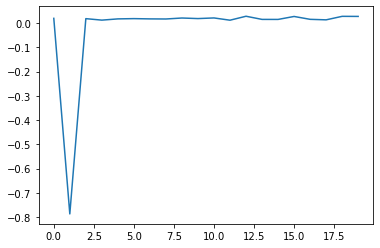

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(history))), [a - 0.9 for a in history])
plt.show()

# It turns out that SGD with the given learning rate doesn't work well.


<!-- Hyperparameter tuning is already an integral part of ML experimentation. But it is not so for experimenting different neural architectures, losses, optimization algorithms and etc. Nerual architecture search is still considered an advanced/complex ML techinique. W -->

See also:
* [NAS with MNIST](https://github.com/google/pyglove/tree/main/examples/automl/mnist)
* [NAS-Bench-101 with PyGlove](https://github.com/google/pyglove/tree/main/examples/automl/nasbench)
* [Evolving Reinforcement Learning Algorithms](https://github.com/google/brain_autorl/blob/main/evolving_rl/EvolvingRL_Demo.ipynb)